In [1]:
%matplotlib inline
from __future__ import division
from random import random
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

### Bass模型简介：
- 假定潜在市场中的消费者受两种力量驱使采纳某一创新：
 - 自身的创新意识，用创新系数p表示
 - 邻居影响，用模仿系数q表示

假定潜在市场中顾客数量为m，初始时刻采纳人数为0，在t时刻，采纳人数为n(t)，未采纳消费者的采纳概率为:

$$p+q\cdot \frac{n(t)}{m}$$

则在t时刻的采纳人数增长可表示为：

$$\frac{dn(t)}{dt} = \left(m-n(t)\right)\cdot \left(p+q\cdot \frac{n(t)}{m}\right)$$

解微分方程，并结合n(t=0)=0并可以求得：

$$n(t)=m\cdot \frac{1-e^{(p+q)\cdot t}}{1+\frac{q}{p}\cdot e^{(p+q)\cdot t}}$$

Bass模型常用来预测新产品在市场中的增长，大量论文基于Bass模型进行扩展，比如加入市场决策变量、考虑季节影响、考虑产品的更新迭代等。这篇论文(`Bass, 1969`)于2004年被评定为`Management Science`期刊过去50年中最具影响力的论文之一(`Bass, 2004`)。

经典的Bass(1969)模型假定潜在市场是一个**全连通的网络**，即一个未采纳创新的个体会受到所有市场中已采纳个体的影响。显然，这个假设是不合适的。大量研究表明，社会网络具有一些典型的结构特征，例如度分布的无标度性，小世界性和社团结构等。本项目主要目标如下：
- 构建网络版Bass模型
- 分析种子节点平均邻居数量对扩散过程的影响，例如：何时达到峰值采纳率、峰值采纳率是多少等

### 一. 模型构建

将潜在市场抽象为一个固定社会网络，其中节点对应于消费者，边对应于消费者之间的关系。

对于网络中的节点，设定以下属性：
- 采纳状态state，取值为False时表示未采纳创新，为True时表示已采纳创新
- 所有影响的节点集合prede，取值为对该节点产生影响的其它所有节点的集合

节点的状态更新规则如下：
- 计算当前阶段未采纳创新节点i的采纳概率prob：$1-(1-p)(1-q)^{number\ of\ adopted\ neighbors}$。
- 通过均匀分布u(0,1)随机产生一个数rand。
- 如果prob >= rand，则节点i的状态由Fasle更新为True。

#### 更新规则

- 可看成一次随机试验
- 如果$x～U(0,1)$，则有$P\{\mathrm{x} <= \mathrm{prob}\} = \mathrm{prob}$

In [27]:
prob = 0.7
s_list = []
for i in xrange(10000):
    if np.random.random() <= prob:
        s_list.append(1)

####  扩散方程: \_diffuse_
- in: G-网络, p外部影响系数, q内部影响吸收, seeds-种子节点集合, number_of_run-模拟时间步数
- out: num_of_adopt-各个时间步中新增采纳者的数量。

In [2]:
def _diffuse_(G,p,q,seeds = [],num_of_run=25):
    if not G.is_directed():
        G = G.to_directed()
        
    for i in G.nodes_iter():
        G.node[i]['state'] = False
        G.node[i]['prede'] = G.predecessors(i)
    
    #将种子节点的采纳状态设置为true
    for i in seeds:
        G.node[i]['state'] = True
        
    non_set = np.array([i for i in G if not G.node[i]['state']])
    num_of_adopt = []         
    for u in xrange(num_of_run):
        #获取所有未采纳节点的已采纳邻居数量
        len_non = len(non_set)
        influ = np.zeros(len_non)
        for i in xrange(len_non):
            influ[i] = len([k for k in G.node[non_set[i]].get('prede',[]) if G.node[k]['state']])
      
        #获取本时间步采纳者数量
        prob = 1-(1-p)*(1-q)**influ
        rand = np.random.random(len_non) #基于numpy生成一组随机数
        upda = rand<=prob
        num_of_adopt.append(np.sum(upda))
        #更新本时间步已采纳节点的状态
        for i in non_set[upda]: #通过逻辑值读取non_set中的元素
            G.node[i]['state'] = True
        
        non_set = non_set[rand>prob] #更新未采纳节点集合         
    return num_of_adopt

In [3]:
def bass_diff(params,len_s): #bass模型
    p,q,m = params
    diffu_cont = np.zeros(len_s)
    t_list = np.arange(1,len_s+ 1)
    a = np.array([1 - np.e**(-(p+q)*t) for t in t_list])
    b = np.array([1 + q/p*np.e**(-(p+q)*t) for t in t_list])
    diffu_cont = m*a/b

    adopt_cont = np.zeros_like(diffu_cont)
    adopt_cont[0] = diffu_cont[0]
    for t in xrange(1,len_s):
        adopt_cont[t] = diffu_cont[t] - diffu_cont[t-1]
        
    return adopt_cont

#### 1. 单次扩散示例

- 网络绘图

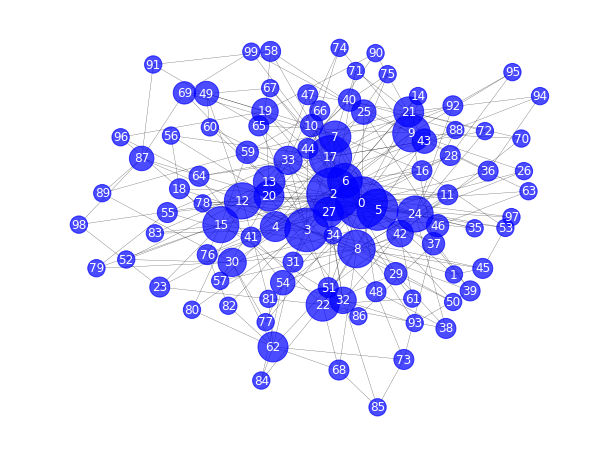

In [44]:
G = nx.barabasi_albert_graph(100,3)
plt.figure(figsize=(10,8))
plt.axis('off')
nx.draw_networkx(G,width=0.3,node_color = 'b', node_size = [100*G.degree(i) for i in G],
                 alpha=0.7, with_labels=True, edge_color = 'k',
                 labels = {x:str(x) for x in G}, font_color='w',font_size=12)

- 单次扩散

In [4]:
n = 10000 #网络中节点数量
k = 3 #新加入节点选择连边节点的数量
G = nx.barabasi_albert_graph(n,k) #nx.gnm_random_graph(n,k*n)
p,q = 0.0001,0.05 #创新系数和模仿系数

In [6]:
t1 = time.clock()
diff = _diffuse_(G,p,q)
np.argmax(diff),np.max(diff)
print time.clock()-t1

1.586564


In [ ]:
diff2 = bass_diff([0.0001,0.3,10000],)

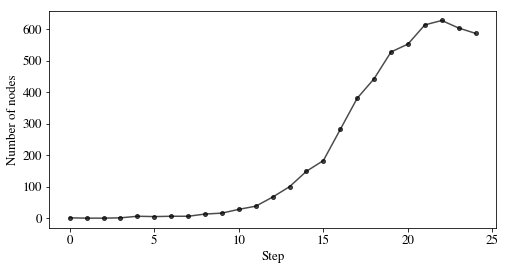

In [7]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Step')
ax.set_ylabel('Number of nodes')
ax.plot(diff,'ko-',ms=4,label='A',alpha=0.7)
plt.show()

### 二、 模型的核实与证实

### 1. corner cases

- 设置所有p为0，如果模型正确，采纳者数量应一直为0

In [5]:
n = 10000 #网络中节点数量
k = 3 #新加入节点选择连边节点的数量
G = nx.barabasi_albert_graph(n,k) #nx.gnm_random_graph(n,k*n)
p,q = 0,0.05 #创新系数和模仿系数

In [6]:
t1 = time.clock()
diff = _diffuse_(G,p,q)
np.argmax(diff),np.max(diff)
print time.clock()-t1

1.336502


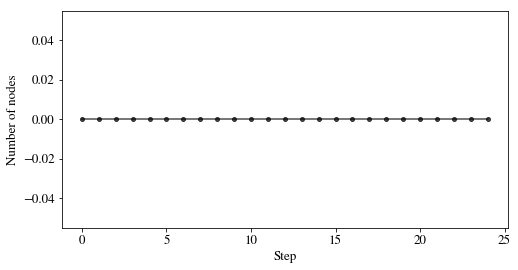

In [7]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Step')
ax.set_ylabel('Number of nodes')
ax.plot(diff,'ko-',ms=4,label='A',alpha=0.7)
plt.show()

- 设置所有的q为0，如果模型正确，每一时期的采纳者数量为随机变量，由p决定

In [35]:
p,q = 0.001,0 #创新系数和模仿系数

In [36]:
diff = _diffuse_(G,p,q)

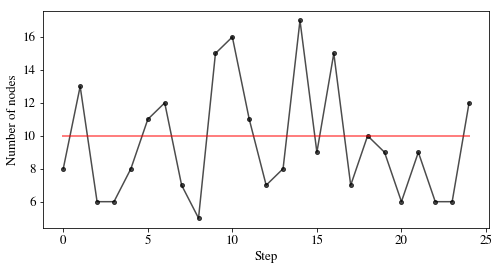

In [37]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Step')
ax.set_ylabel('Number of nodes')
ax.plot(diff,'ko-',ms=4,alpha=0.7)
ax.plot(np.ones_like(diff)*10000*p,'r-',lw=2,alpha=0.5)
plt.show()

### 2. relative value testing

- p逐渐增大，如果模型正确，则采纳者数量峰值出现得更早

In [11]:
p_cont = [0.0001,0.001,0.01]
q = 0.05

In [13]:
diff_cont = []
for p in p_cont:
    diff = _diffuse_(G,p,q)
    diff_cont.append(diff)

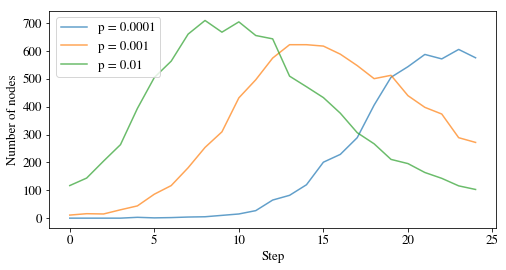

In [14]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Step')
ax.set_ylabel('Number of nodes')
for i,x in enumerate(diff_cont):
    ax.plot(x,label='p = %s'%p_cont[i],alpha=0.7)
plt.legend(loc='best')
plt.show()

- q逐渐增大，如果模型正确，则采纳者数量峰值出现得更早

In [15]:
p = 0.001
q_cont = [0.005,0.05,0.2]

In [16]:
diff_cont = []
for q in q_cont:
    diff = _diffuse_(G,p,q)
    diff_cont.append(diff)

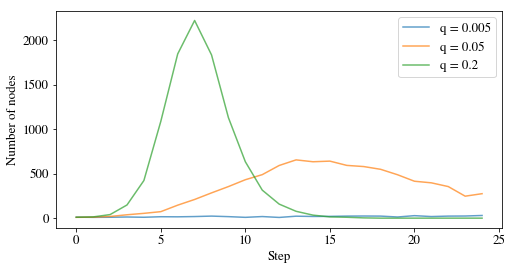

In [17]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Step')
ax.set_ylabel('Number of nodes')
for i,x in enumerate(diff_cont):
    ax.plot(x,label='q = %s'%q_cont[i],alpha=0.7)
plt.legend(loc='best')
plt.show()

### 3. cross-validation

In [22]:
n = 10000 #网络中节点数量
k = 3 #新加入节点选择连边节点的数量
G = nx.barabasi_albert_graph(n,k) #nx.gnm_random_graph(n,k*n)

In [33]:
diff_1 = _diffuse_(G,0.001,0.05)
diff_2 = bass_diff([0.001,0.3,10000],25)

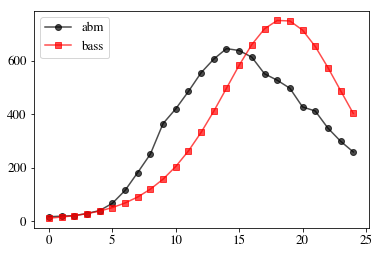

In [34]:
plt.plot(diff_1,'ko-',alpha=0.7,label='abm')
plt.plot(diff_2,'rs-',alpha=0.7,label='bass')
plt.legend(loc='best')

### 三. 不同种子节点集合的扩散对比

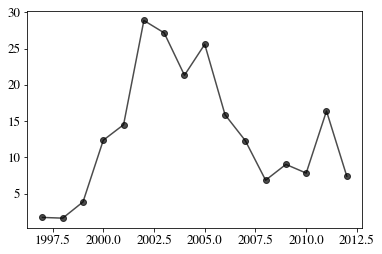

In [38]:
china_set = {'color tv':(np.arange(1997,2013),[2.6,1.2,2.11,3.79,3.6,7.33,7.18,5.29,8.42,5.68,6.57,5.49,6.48,5.42,10.72,5.15]),
             'mobile phone':(np.arange(1997,2013),[1.7,1.6,3.84,12.36,14.5,28.89,27.18,21.33,25.6,15.88,12.3,6.84,9.02,7.82,16.39,7.39]),
             }
plt.plot(china_set['mobile phone'][0],china_set['mobile phone'][1],'ko-',alpha=0.7)

In [39]:
u = '/Users/xiaoyu/Documents/Dissertation/Fitting ABM/'
db_ba = np.load(u+'database for ba.npy')

#### 设置扩散初始参数

In [9]:
n = 10000 #网络中节点数量
k = 3 #新加入节点选择连边节点的数量
G = nx.barabasi_albert_graph(n,k) #nx.gnm_random_graph(n,k*n)
p,q = 0.0001,0.05 #创新系数和模仿系数

#### 节点按照度的大小降序排列

In [10]:
degre_list = [] #用于保存[i的度，i]
for i in G.nodes():
    degre_list.append([nx.degree(G,i),i])

degre_list = sorted(degre_list,reverse=True) #根据节点的度由大到小排序
degre_list = np.array(degre_list) #转化为nump.ndarray

#### 生成扩散数据，保存对应指标

In [11]:
degre_seed_list = [] #保存种子节点的平均度
p_list = [] #保存p
q_list = [] #保存q
peak_number_list = [] #保存峰值采纳率
peak_step_list = [] #保存到达峰值采纳率的时间步

t1 = time.clock()
for i in xrange(0,1000,10):
    sele_list = degre_list[i:(i+10)]
    seeds = sele_list[:,1]
    ave_degr = np.mean(sele_list[:,0])
    diff = _diffuse_(G,p,q,seeds=seeds)
    
    if i in xrange(100,1000,100):
        print '循环次数:%d, Time consumed:%s s'%(i,time.clock()-t1)
        t1 = time.clock()
        
    degre_seed_list.append(ave_degr)
    p_list.append(p)
    q_list.append(q)
    peak_number_list.append(np.max(diff))
    peak_step_list.append(np.argmax(diff))

循环次数:100, Time consumed:11.967597 s
循环次数:200, Time consumed:10.327336 s
循环次数:300, Time consumed:11.767704 s
循环次数:400, Time consumed:12.431167 s
循环次数:500, Time consumed:10.674507 s
循环次数:600, Time consumed:10.652083 s
循环次数:700, Time consumed:10.670919 s
循环次数:800, Time consumed:10.370766 s
循环次数:900, Time consumed:11.941069 s


#### 将数据保存为DataFrame

In [12]:
pd_diff = pd.DataFrame({'p':p_list,'q':p_list,'degr_seed':degre_seed_list,
                        'peak_number':peak_number_list,'peak_step':peak_step_list})

In [13]:
pd_diff.describe()

,degr_seed,p,peak_number,peak_step,q
count,100.00000,1.000000e+02,100.000000,100.000000,1.000000e+02
mean,20.90600,1.000000e-04,634.960000,14.600000,1.000000e-04
std,21.14609,5.448321e-20,15.759506,1.632993,5.448321e-20
min,10.00000,1.000000e-04,590.000000,10.000000,1.000000e-04
25%,11.82500,1.000000e-04,623.750000,14.000000,1.000000e-04
50%,15.00000,1.000000e-04,635.000000,15.000000,1.000000e-04
75%,21.12500,1.000000e-04,644.250000,16.000000,1.000000e-04
max,180.70000,1.000000e-04,671.000000,19.000000,1.000000e-04


In [ ]:
path = '/Users/xiaoyu/Documents'
pd_diff.to_csv(path+'/pd_diff.csv')

#### 分析数据

In [ ]:
pd_diff = pd.read_csv(path+'/pd_diff.csv',index_col=0,parse_dates=True)

- 绘图

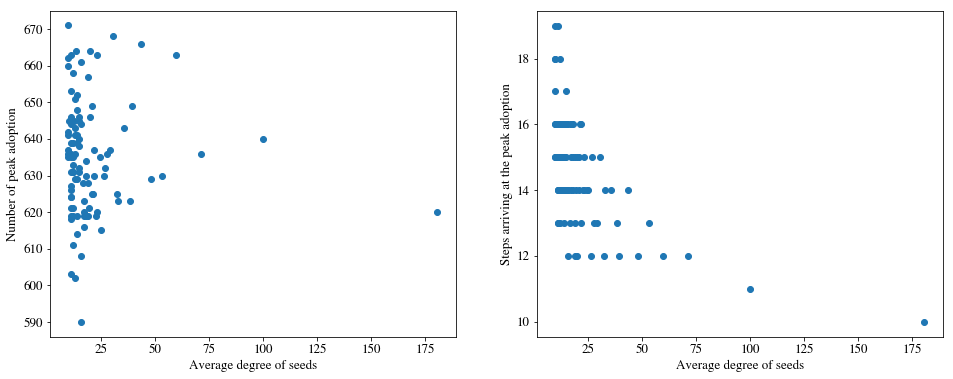

In [52]:
fig = plt.figure(figsize=(16,6))
ax0 = fig.add_subplot(1,2,1)
ax0.scatter(pd_diff['degr_seed'],pd_diff['peak_number'])
ax0.set_xlabel('Average degree of seeds')
ax0.set_ylabel('Number of peak adoption')

ax1 = fig.add_subplot(1,2,2)
ax1.scatter(pd_diff['degr_seed'],pd_diff['peak_step'])
ax1.set_xlabel('Average degree of seeds')
ax1.set_ylabel('Steps arriving at the peak adoption')

- 回归分析

In [46]:
result1 = smf.ols('peak_number ~ degr_seed',data=pd_diff).fit()
cof1_1 = result1.params['degr_seed']
cof1_2 = result1.params['Intercept']
r2_1 = result1.rsquared

In [40]:
print result1.summary()

                            OLS Regression Results                            
Dep. Variable:            peak_number   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.03304
Date:                Fri, 12 May 2017   Prob (F-statistic):              0.856
Time:                        13:34:36   Log-Likelihood:                -417.12
No. Observations:                 100   AIC:                             838.2
Df Residuals:                      98   BIC:                             843.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    635.2460      2.233    284.536      0.0

In [44]:
result2 = smf.ols('peak_step ~ degr_seed',data=pd_diff).fit()
print result2.summary()
cof2_1 = result2.params['degr_seed']
cof2_2 = result2.params['Intercept']

                            OLS Regression Results                            
Dep. Variable:              peak_step   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     44.51
Date:                Fri, 12 May 2017   Prob (F-statistic):           1.51e-09
Time:                        13:36:41   Log-Likelihood:                -171.71
No. Observations:                 100   AIC:                             347.4
Df Residuals:                      98   BIC:                             352.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5023      0.192     80.795      0.0

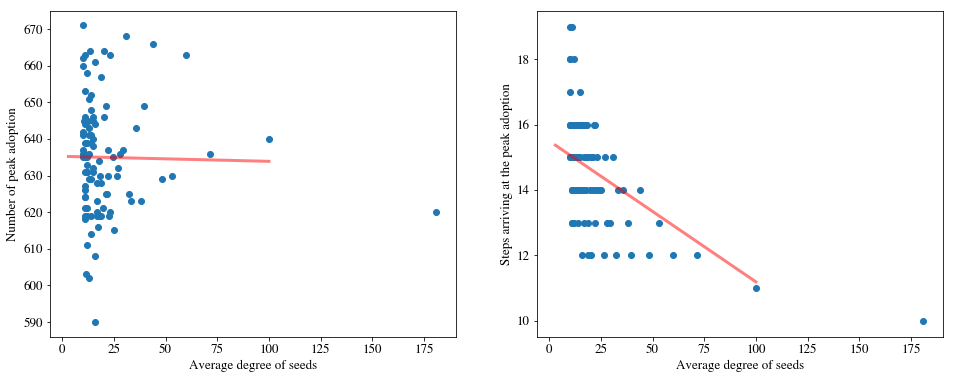

In [48]:
x = np.linspace(3,100)

fig = plt.figure(figsize=(16,6))
ax0 = fig.add_subplot(1,2,1)
ax0.plot(x,cof1_1*x+cof1_2,'r-',lw=3,alpha=0.5)
ax0.scatter(pd_diff['degr_seed'],pd_diff['peak_number'])
ax0.set_xlabel('Average degree of seeds')
ax0.set_ylabel('Number of peak adoption')


ax1 = fig.add_subplot(1,2,2)
ax1.plot(x,cof2_1*x+cof2_2,'r-',lw=3,alpha=0.5)
ax1.scatter(pd_diff['degr_seed'],pd_diff['peak_step'])
ax1.set_xlabel('Average degree of seeds')
ax1.set_ylabel('Steps arriving at the peak adoption')